In [59]:
from matplotlib import pyplot as plt
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from PIL import Image
import numpy as np
from src.gan import getGanModel

import cv2
import pandas as pd
import os
from tqdm import tqdm

In [60]:
def plotSaveImage(image, savePath = ''):
    data = (gImage.numpy() * 255)[0]
    plt.imshow(data)
    plt.show()
    if len(savePath):
        rescaled = (255.0 / data.max() * (data - data.min())).astype(np.uint8)
        im = Image.fromarray(rescaled)
        im.save(savePath)

In [61]:
gan, generator, discriminator = getGanModel()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


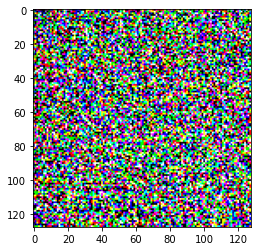

In [62]:
# Test Generator image
features = tf.random.normal(shape=[1, 40])
randomNoise = tf.random.normal(shape=[1, 100])
gImage = generator([features, randomNoise], training=False)
# gImage = generator([randomNoise, features], training=False)
plotSaveImage(gImage)

In [63]:
decision = discriminator([features, gImage])
print(decision)

tf.Tensor([[0.5010394]], shape=(1, 1), dtype=float32)


In [74]:
picsPath = 'P:/GAN Learning/Face_Generation/datasets/29561_37705_bundle_archive/img_align_celeba/processed/'
csvPath = 'P:/GAN Learning/Face_Generation/datasets/29561_37705_bundle_archive/list_attr_celeba.csv'
data = pd.read_csv(csvPath)
numpyData = data.values
# print(len(numpyData))

202599


In [78]:
batchSize = 25
start = 0
iterations = 10
randomNoiseLength = 100


picNames = numpyData[start:start+batchSize, 0]
attributes = numpyData[start:start+batchSize, 1:]
attributes = np.asarray(attributes).astype('float32')
attributes += 0.05 * np.random.random(attributes.shape)

In [79]:
def getMetaData(rawData, start, batchSize, rootPath = ''):
    picNames = rawData[start:start+batchSize, 0]
    attributes = rawData[start:start+batchSize, 1:]
    attributes = np.asarray(attributes).astype('float32')
    attributes += 0.05 * np.random.random(attributes.shape)
    
    if len(rootPath):
        images = getImages(rootPath, picNames)
        return (images, attributes)
    return (picNames, attributes)
    

In [80]:
print(attributes.shape, type(attributes))
print(picNames.shape)
randomVector = np.random.normal(size=(batchSize, randomNoiseLength))
print(randomVector.shape, type(randomVector))
print(features.shape)
print(randomNoise.shape)

(25, 40) <class 'numpy.ndarray'>
(25,)
(25, 100) <class 'numpy.ndarray'>
(1, 40)
(1, 100)


In [81]:
print(attributes)

[[-0.9598997   1.0037706   1.0234942  -0.9601756  -0.9518774  -0.99763685
  -0.98219365 -0.9992814  -0.9747535  -0.9572441  -0.9691286   1.0444156
  -0.97121936 -0.9680691  -0.99976116 -0.9732849  -0.98239976 -0.9724458
   1.0085076   1.0408657  -0.9790358   1.0025401  -0.9890178  -0.96212465
   1.0049442  -0.96554834 -0.97827446  1.011642   -0.9600358  -0.9883734
  -0.97818524  1.0135598   1.0378128  -0.9513214   1.0282247  -0.95350015
   1.007851   -0.95125663 -0.98999584  1.040301  ]
 [-0.9717277  -0.99080014 -0.99480397  1.0428014  -0.9965713  -0.97519237
  -0.9827753   1.0310506  -0.98431087 -0.980475   -0.9804239   1.000613
  -0.97120583 -0.9790009  -0.9918384  -0.99836445 -0.9811362  -0.9697223
  -0.96420115  1.0407828  -0.9947261   1.0011193  -0.99820906 -0.9745202
   1.0078218  -0.96192354 -0.97395647 -0.96675026 -0.96080226 -0.9752156
  -0.9841977   1.0327411  -0.95636046 -0.9804207  -0.97237045 -0.9809801
  -0.972268   -0.95074344 -0.970289    1.0052406 ]
 [-0.9752092  -0.99

In [82]:
def getImages(rootPath, imageList):
    images = []
    for i in imageList:
        temp = cv2.imread(rootPath + i)
        temp = cv2.cvtColor(temp, cv2.COLOR_BGR2RGB)
        temp = temp / 255
        images.append(temp)
    return np.array(images)

In [83]:
images = getImages(picsPath, picNames)

In [84]:
print(images.shape)

(25, 128, 128, 3)


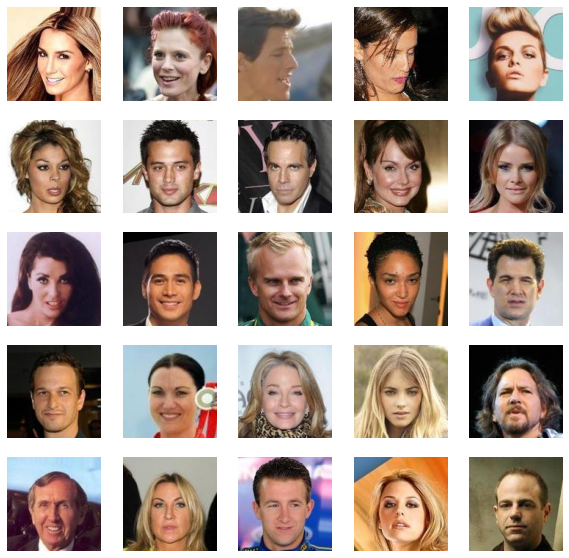

In [85]:
plt.figure(1, figsize=(10, 10))
for i in range(batchSize):
    plt.subplot(5, 5, i+1)
    plt.imshow(images[i])
    plt.axis('off')
plt.show()
    

In [98]:
discriminatorLosses = []
adversaryLosses = []
start = 42500 + 25000
iterations = 1000

for step in tqdm(range(iterations)):    
    # Fetching the images and their attributes from Hard drive
    realImages, attributes = getMetaData(numpyData, start, batchSize, picsPath)
    
    # Random vector (2nd Generator Input)
    randomVector = np.random.normal(size=(batchSize, randomNoiseLength))
    
    # Generating fake images
    generatedImages = generator.predict([attributes, randomVector])
    
    # Combining 50% fake and 50% real images as well as attributes for discriminator
    combinedImages = np.concatenate([generatedImages, realImages])
    combinedAttributes = np.concatenate([attributes, attributes])
    # 0 => Label for fake images, 1 => Label for real images >>> Used to train Discriminator
    labels = np.concatenate([np.zeros((batchSize, 1)), np.ones((batchSize, 1))])
    labels += .05 * np.random.random(labels.shape)
    
    # Training Discriminator
    discriminatorLoss = discriminator.train_on_batch([combinedAttributes, combinedImages], labels)
    discriminatorLosses.append(discriminatorLoss)
    
    # Preparing to train Generator
    misleadingTargets = np.ones((batchSize, 1))
    misleadingTargets += .05 * np.random.random(misleadingTargets.shape)
    
#     # Random vector (2nd Generator Input)
#     randomVector = np.random.normal(size=(batchSize, randomNoiseLength))
    
    # Training Generator
    adversaryLoss = gan.train_on_batch([randomVector, attributes], misleadingTargets)
    adversaryLosses.append(adversaryLoss)
    
    start += batchSize
    if start > len(numpyData) - batchSize:
        start = 0
        
    

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [05:06<00:00,  3.26it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

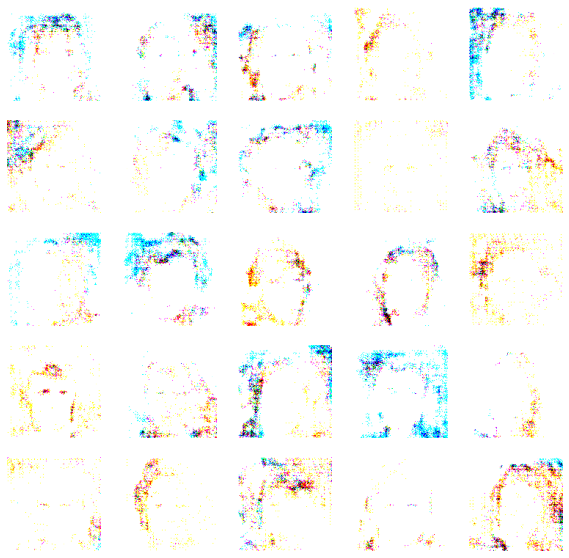

In [99]:
tempGeneratedImages = generatedImages * 255

plt.figure(1, figsize=(10, 10))
for i in range(batchSize):
    plt.subplot(5, 5, i+1)
    plt.imshow(tempGeneratedImages[i])
    plt.axis('off')
plt.show()